In [1]:
%matplotlib ipympl
import torch
from torch import nn
from pit.dynamics import Dynamics
from pit.integration import RK4, Euler
from numpy import pi
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider
from tqdm.autonotebook import tqdm
plt.ioff();

In [119]:
class Bicycle(Dynamics, nn.Module):
    """
    This is a kinematic bicycle model, with the center of the vehicle as the control point. 
    Based on 
    https://thomasfermi.github.io/Algorithms-for-Automated-Driving/Control/BicycleModel.html
    """
    def __init__(self, wheelbase) -> None:
        super().__init__()
        self.wb = torch.nn.Parameter(torch.tensor(wheelbase, dtype=torch.float32))

    def forward(self, states, control_inputs):
        """ Get the evaluated ODEs of the state at this point

        Args:
            states (): Shape of (B, 4) or (4)
            control_inputs (): Shape of (B, 2) or (2)
        """
        batch_mode = True if len(states.shape)==2 else False
        X, Y, THETA, V = 0, 1, 2, 3
        STEER, ACCEL = 0, 1
        diff = torch.zeros_like(states)
        diff[..., X] = (states[..., V] + self.wb/2) * torch.cos(states[..., THETA])
        diff[..., Y] = (states[..., V] + self.wb/2) * torch.sin(states[..., THETA])
        diff[..., THETA] = (states[..., V] * torch.tan(control_inputs[..., STEER])/self.wb)
        diff[..., V] = control_inputs[..., ACCEL]
        return diff

class Unicycle(Dynamics, nn.Module):
    """
    This is a kinematic bicycle model, with the center of the vehicle as the control point. 
    Based on 
    https://thomasfermi.github.io/Algorithms-for-Automated-Driving/Control/BicycleModel.html
    """
    def __init__(self) -> None:
        super().__init__()

    def forward(self, states, control_inputs):
        """ Get the evaluated ODEs of the state at this point

        Args:
            states (): Shape of (B, 4) or (4)
            control_inputs (): Shape of (B, 2) or (2)
        """
        batch_mode = True if len(states.shape)==2 else False
        X, Y, THETA, V = 0, 1, 2, 3
        STEER, ACCEL = 0, 1
        diff = torch.zeros_like(states)
        diff[..., X] = states[..., V] * torch.cos(states[..., THETA])
        diff[..., Y] = states[..., V] * torch.sin(states[..., THETA])
        diff[..., THETA] = control_inputs[..., STEER]
        diff[..., V] = control_inputs[..., ACCEL]
        return diff

        
class DummyU(nn.Module):
    def __init__(self, steps, rand=False):
        super().__init__()
        if rand:
            self.u = torch.nn.Parameter(torch.rand(steps,2))
            # Set steering to proper domain
            self.u[:, 0] = (self.u[:, 0]-0.5)*(2*7*pi/16)
            # Set accel to proper domain
            self.u[:, 1] = (self.u[:, 0]-0.5)*(2*10)
        else:
            self.u = torch.nn.Parameter(torch.zeros(steps,2))
    
    def forward(self, *args):
        return self.u

In [110]:
u = torch.zeros(4,2)
u[0] = torch.tensor([0, 1])
u[1] = torch.tensor([-(pi/4), 0])
u[2] = torch.tensor([-(pi/4), 0])
u[3] = torch.tensor([0, 0])
u.requires_grad = True
u.retain_grad()
dum_u = DummyU(4)
x0 = torch.tensor([0.0, 0.0, 0.0, 0.1])
model = Bicycle(0.1)
integrator = RK4(model)#, include_initial_state=False)
def loss_fn(pred, target, u): 
    return nn.functional.l1_loss(pred[:,:2], target[:,:2]) #+ 1e-5*torch.linalg.norm(u)
optim = torch.optim.SGD(dum_u.parameters(), lr=1, momentum=0.9)

In [111]:
targetU = torch.tensor([
    [ 0.0000,  1.0000],
    [ pi/4,  0.0000],
    [ pi/4,  0.0000],
    [ -pi/4,  0.0000],
])
targetX = integrator(x0, targetU)[:,:2]
targetX = targetX.detach()
targetX

tensor([[0.0200, 0.0000],
        [0.0450, 0.0000],
        [0.0695, 0.0050],
        [0.0925, 0.0147]])

In [112]:
X = integrator(x0, dum_u())
X

tensor([[0.0150, 0.0000, 0.0000, 0.1000],
        [0.0300, 0.0000, 0.0000, 0.1000],
        [0.0450, 0.0000, 0.0000, 0.1000],
        [0.0600, 0.0000, 0.0000, 0.1000]], grad_fn=<StackBackward0>)

In [113]:
def evaluate_iteration(x0, u, targetX, idx=None):
    u = dum_u()
    X = integrator(x0, dum_u())
    #print("Output States:")
    #print(X)
    #plt.plot(X[:,0].detach().numpy(), X[:,1].detach().numpy(), marker="x")
    positions.append((X[:,0].detach().numpy(), X[:,1].detach().numpy()))
    #plt.show()
    if i is not None:
        #loss = loss_fn(X[-i:,:2], targetX[-i:])
        loss = loss_fn(X[:i], targetX[:i], u)
    else:
        loss = loss_fn(X, targetX, u)
    #print(f"Loss: {loss.item()}")
    optim.zero_grad()
    losses.append(loss.item())
    loss.backward()
    u_grad = u.grad
    targ_grad = targetU - u
    #print("u gradient error")
    #print(targ_grad - u_grad)
    gradient_errors.append(torch.linalg.norm(targ_grad - u_grad).item())
    optim.step()
    return u

In [114]:
gradient_errors = list()
positions = list()
losses = list()
N = 1000
for i in tqdm(range(N)):
    idx = i//2000
    u = evaluate_iteration(x0, u, targetX, None)
    #print("u-value:")
    #print(u)
    #print("-------------------------------------------")

  0%|          | 0/1000 [00:00<?, ?it/s]

In [115]:
len(positions)

1000

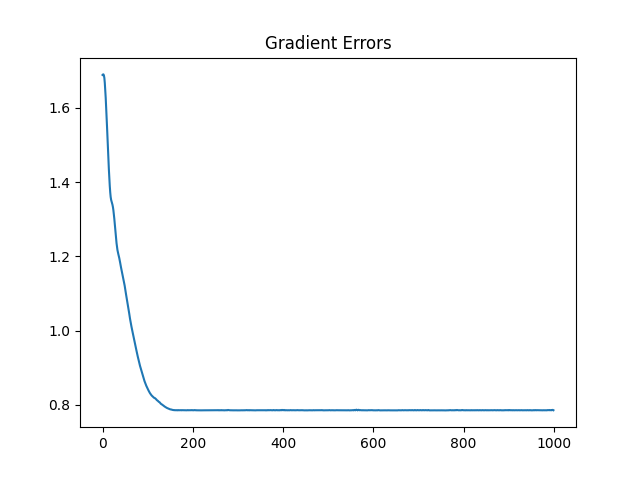

In [116]:
with plt.ioff():
    plt.figure(1)
    plt.clf()
    plt.plot(gradient_errors)
    plt.title("Gradient Errors")
    plt.show()

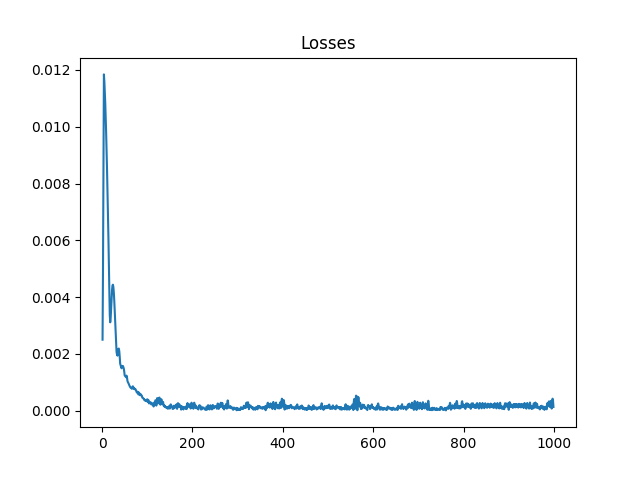

In [117]:
with plt.ioff():
    plt.figure(2)
    plt.clf()
    plt.plot(losses)
    plt.title("Losses")
    plt.show()

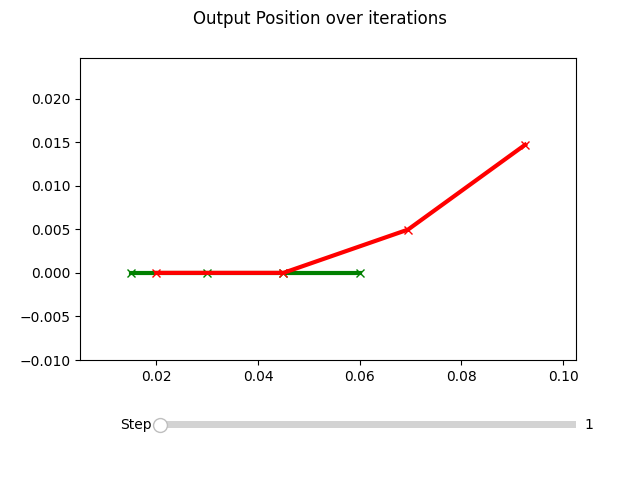

In [118]:
# Setting Plot and Axis variables as subplots()
# function returns tuple(fig, ax)
fig, ax = plt.subplots()
fig.suptitle("Output Position over iterations")
# Adjust the bottom size according to the
# requirement of the user
plt.subplots_adjust(bottom = 0.25)
 
# Set the x and y axis to some dummy data
t = 1
# plot the x and y using plot function
Plot, = plt.plot(positions[t][0], positions[t][1], lw = 3, marker='x', color = 'green')
TPlot = plt.plot(targetX[:,0].detach().numpy(), targetX[:,1].detach().numpy(), lw = 3, marker='x', color = 'red')


ax.set_xlim(np.array([positions[t][0],targetX[:,0].detach().numpy()]).min()-0.01, 
            np.array([positions[t][0],targetX[:,0].detach().numpy()]).max()+0.01)
ax.set_ylim(np.array([positions[t][1],targetX[:,1].detach().numpy()]).min()-0.01, 
            np.array([positions[t][1],targetX[:,1].detach().numpy()]).max()+0.01)
#plt.axis([0, 1, -10, 10])
 
# Choose the Slider color
axcolor = "White"
 
# Set the frequency and amplitude axis
time_axis = plt.axes([0.25, 0.1, 0.65, 0.03],
                          facecolor = axcolor)
 
# Set the slider for frequency and amplitude
t_slider = Slider(time_axis, 'Step',
                  0.0, len(positions), 
                  valinit = t, valstep = 1.0)
 
# update() function to change the graph when the
# slider is in use
def update(val):
    t = int(t_slider.val)
    Plot.set_xdata(positions[t][0])
    Plot.set_ydata(positions[t][1])
    ax.set_xlim(np.array([positions[t][0],targetX[:,0].detach().numpy()]).min()-0.01, 
                np.array([positions[t][0],targetX[:,0].detach().numpy()]).max()+0.01)
    ax.set_ylim(np.array([positions[t][1],targetX[:,1].detach().numpy()]).min()-0.01, 
                np.array([positions[t][1],targetX[:,1].detach().numpy()]).max()+0.01)
     
# update function called using on_changed() function
# for both frequency and amplitude
t_slider.on_changed(update)

# Display the plot
plt.show()

In [97]:
u

Parameter containing:
tensor([[0.3404, 0.8264],
        [0.2555, 0.2917],
        [0.1328, 0.0825],
        [0.0000, 0.0000]], requires_grad=True)

In [98]:
X = integrator(x0, u)
X

tensor([[0.0191, 0.0005, 0.0501, 0.1826],
        [0.0424, 0.0016, 0.0978, 0.2118],
        [0.0684, 0.0042, 0.1261, 0.2201],
        [0.0952, 0.0076, 0.1261, 0.2201]], grad_fn=<StackBackward0>)

In [99]:
targetU

tensor([[ 0.0000,  1.0000],
        [ 0.7854,  0.0000],
        [ 0.7854,  0.0000],
        [-0.7854,  0.0000]])

In [100]:
u-targetU

tensor([[ 0.3404, -0.1736],
        [-0.5299,  0.2917],
        [-0.6526,  0.0825],
        [ 0.7854,  0.0000]], grad_fn=<SubBackward0>)

In [16]:
np.argmax(np.array(losses)<0.01)

1

In [17]:
np.argmax(np.array(losses)<0.001)

58

In [18]:
np.argmax(np.array(losses)<0.0001)

145

In [19]:
np.argmax(np.array(losses)<0.00001)

761

In [77]:
dum_u = DummyU(2)
x0 = torch.tensor([0.0, 0.0, 0.0, 0.1])
model = Bicycle(0.1)
euler_integrator = Euler(model)#, include_initial_state=False)
rk4_integrator = RK4(model)
def loss_fn(pred, target, u): 
    return nn.functional.mse_loss(pred[:,:2], target[:,:2]) #+ 1e-5*torch.linalg.norm(u)
optim = torch.optim.SGD(dum_u.parameters(), lr=1, momentum=0.9)

In [78]:
targetU = torch.tensor([
    [ 0.0000,  1.0000],
    [ pi/4,  0.0000]
])
targetX = integrator(x0, targetU)[:,:2]
targetX = targetX.detach()
targetX

tensor([[0.0200, 0.0000],
        [0.0450, 0.0000]])

In [79]:
integrator(x0, dum_u())

tensor([[0.0150, 0.0000, 0.0000, 0.1000],
        [0.0300, 0.0000, 0.0000, 0.1000]], grad_fn=<StackBackward0>)

In [80]:
def loss(u, x0, targetX, integrator=euler_integrator):
    pred = integrator(x0, u)
    loss = loss_fn(pred, targetX, u)
    return loss.item()

In [81]:
steer = np.arange(-8*np.pi/16, 8*np.pi/16, 16*np.pi/(16*200))
accel = np.arange(-80, 80, 160/200)
data = np.zeros((200, 200))
for i in tqdm(range(200)):
    for j in range(200):
        u = torch.tensor([
            [steer[i], accel[j]],
            [0, 0]
        ])
        data[i, j] = loss(u, x0, targetX)


  0%|          | 0/200 [00:00<?, ?it/s]

In [82]:
steer.shape

(200,)

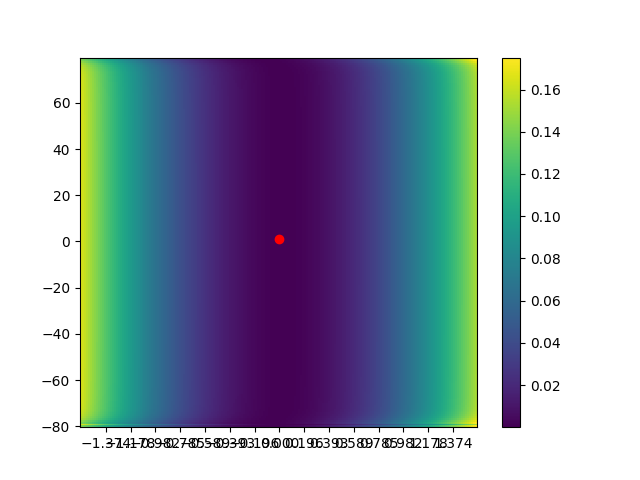

In [83]:
fig, ax = plt.subplots()
c = ax.pcolormesh(steer, accel, data)
ax.set_xticks([x*np.pi/16 for x in range(-7, 8, 1)])
#ax.set_aspect('equal')
ax.scatter(targetU[0][0], targetU[0][1], color='red')
fig.colorbar(c)
plt.show()

In [84]:
RESOLUTION = 200
steer = np.arange(-8*np.pi/16, 8*np.pi/16, 16*np.pi/(16*RESOLUTION))
accel = np.arange(-80, 80, 160/RESOLUTION)
data = np.zeros((RESOLUTION, RESOLUTION))
for i in tqdm(range(RESOLUTION)):
    for j in range(RESOLUTION):
        u = torch.tensor([
            [steer[i], accel[j]],
            [0, 0]
        ])
        data[i, j] = loss(u, x0, targetX, rk4_integrator)


  0%|          | 0/200 [00:00<?, ?it/s]

In [85]:
min_steer_idx, min_accel_idx = np.unravel_index(np.argmin(data), data.shape)

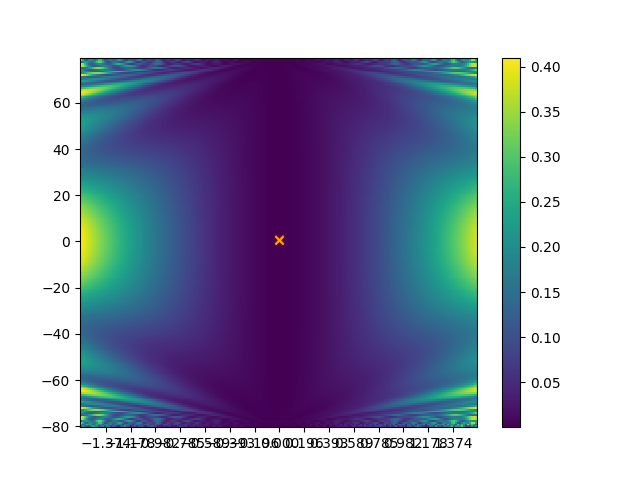

In [86]:
fig, ax = plt.subplots()
c = ax.pcolormesh(steer, accel, data)
ax.set_xticks([x*np.pi/16 for x in range(-7, 8, 1)])
#ax.set_aspect('equal')
ax.scatter(targetU[0][0], targetU[0][1], color='red', marker='x')
ax.scatter(steer[min_steer_idx], accel[min_accel_idx], color='orange', marker='x')
fig.colorbar(c)
plt.show()

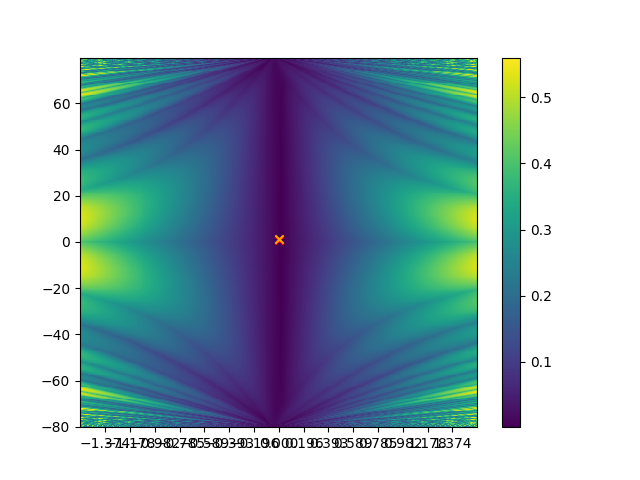

In [46]:
fig, ax = plt.subplots()
c = ax.pcolormesh(steer, accel, data)
ax.set_xticks([x*np.pi/16 for x in range(-7, 8, 1)])
#ax.set_aspect('equal')
ax.scatter(targetU[0][0], targetU[0][1], color='red', marker='x')
ax.scatter(steer[min_steer_idx], accel[min_accel_idx], color='orange', marker='x')
fig.colorbar(c)
plt.show()

In [28]:
u[0]

tensor([ 1.5551, 79.2000], dtype=torch.float64)

In [29]:
import seaborn as sns

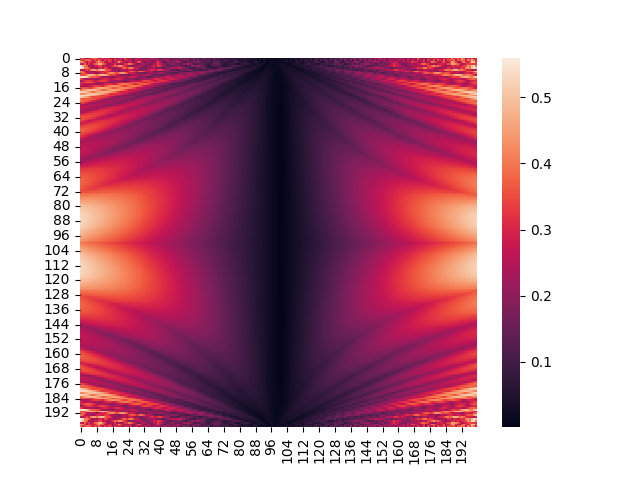

In [30]:
sns.heatmap(data)
plt.show()